In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

import pickle

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")


DATA_DIR   = Path('../data')     
MODELS_DIR = Path('../models')   
OUTPUTS_DIR= Path('../outputs')   


MODELS_DIR.mkdir(parents=True, exist_ok=True)
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

TensorFlow: 2.20.0
GPU Available: False


In [2]:
# ============================================================================
# STEP 1: DATA LOADING
# ============================================================================

def load_gtsrb_dataset(data_dir=DATA_DIR):
    """
    Load  dataset from directory structure
    
    Expected structure:
    data/
    └── Train/
        ├── 0/
        ├── 1/
        └── ... (up to 42)

    Download: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
    """
    print("\n" + "="*70)
    print("LOADING  DATASET")
    print("="*70)
    
    images = []
    labels = []
    
    train_path = Path(data_dir) / 'Train'
    if not train_path.exists():
        raise FileNotFoundError(
            f"Dataset not found at {train_path}!\n"
            "Please download GTSRB and extract so that 'data/Train/<class>/*' exists."
        )
    
    classes = sorted([d for d in os.listdir(train_path) if (train_path / d).is_dir()])
    print(f"Found {len(classes)} classes")
    
    for class_num in classes:
        class_path = train_path / class_num
        class_images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.ppm'))]
        
        for img_name in class_images:
            img_path = class_path / img_name
            img = cv2.imread(str(img_path))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(int(class_num))
        
        if int(class_num) % 10 == 0:
            print(f"  Loaded class {class_num}...")
    
    labels = np.array(labels)
    print(f"\n✓ Successfully loaded {len(images)} images")
    print(f"✓ Example image shape: {images[0].shape} (will be resized)")
    print(f"✓ Number of classes: {len(np.unique(labels))}")
    return images, labels

In [3]:
# ============================================================================
# STEP 2: DATA PREPROCESSING
# ============================================================================

def preprocess_data(images, labels, img_size=32):
    """
    Preprocess images for MLP training
    """
    print("\n" + "="*70)
    print("PREPROCESSING DATA")
    print("="*70)
    
    print(f"Resizing images to {img_size}x{img_size}...")
    resized_images = np.array([cv2.resize(img, (img_size, img_size)) for img in images])
    
    print("Normalizing pixel values...")
    normalized_images = resized_images.astype('float32') / 255.0
    
    print("Flattening images...")
    flattened_images = normalized_images.reshape(len(normalized_images), -1)
    
    n_classes = len(np.unique(labels))
    labels_categorical = to_categorical(labels, n_classes)
    
    print(f"\n✓ Preprocessed shape: {flattened_images.shape}")
    print(f"✓ Each image: {img_size}x{img_size}x3 = {flattened_images.shape[1]} features")
    print(f"✓ Labels shape: {labels_categorical.shape}")
    return flattened_images, labels_categorical, n_classes, normalized_images

In [4]:
# ============================================================================
# STEP 3:  DATA ANALYSIS
# ============================================================================

def visualize_samples(images, labels, n_samples=20):
    """
    Display random sample images from dataset
    """
    print("\nVisualizing sample images...")
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Sample Traffic Signs from Dataset', fontsize=16, fontweight='bold')
    
    indices = np.random.choice(len(images), n_samples, replace=False)
    for i, ax in enumerate(axes.flat):
        idx = indices[i]
        ax.imshow(images[idx])
        label = np.argmax(labels[idx]) if len(getattr(labels[idx], "shape", ())) > 0 else labels[idx]
        ax.set_title(f'Class: {label}', fontsize=11)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'samples.png', dpi=150, bbox_inches='tight')
    plt.show()

def plot_class_distribution(labels):
    """
    Show distribution of traffic sign classes
    """
    print("\nPlotting class distribution...")
    if len(getattr(labels, "shape", ())) > 1:
        class_counts = np.argmax(labels, axis=1)
    else:
        class_counts = labels
    
    plt.figure(figsize=(16, 5))
    unique, counts = np.unique(class_counts, return_counts=True)
    plt.bar(unique, counts, color='steelblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Traffic Sign Class', fontsize=13)
    plt.ylabel('Number of Images', fontsize=13)
    plt.title('Distribution of Traffic Sign Classes in Dataset', fontsize=15, fontweight='bold')
    plt.xticks(unique)
    plt.grid(axis='y', alpha=0.3)
    for i, (cls, cnt) in enumerate(zip(unique, counts)):
        if i % 3 == 0:
            plt.text(cls, cnt + max(5, int(0.01 * counts.max())), str(cnt), ha='center', fontsize=8)
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'class_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Class distribution plotted")
    print(f"  Min samples per class: {counts.min()}")
    print(f"  Max samples per class: {counts.max()}")
    print(f"  Average samples per class: {counts.mean():.0f}")

In [5]:
# ============================================================================
# STEP 4: BUILD MLP MODEL
# ============================================================================

def build_mlp_model(input_shape, n_classes):
    """
    Build Multi-Layer Perceptron architecture:
    512 → 256 → 128 → n_classes
    """
    print("\n" + "="*70)
    print("BUILDING MLP MODEL")
    print("="*70)
    
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_shape,), name='hidden_layer_1'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu', name='hidden_layer_2'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu', name='hidden_layer_3'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(n_classes, activation='softmax', name='output_layer')
    ], name='Traffic_Sign_MLP')
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print("\n✓ Model built successfully")
    return model

In [6]:
# ============================================================================
# STEP 5: TRAIN DL MODEL
# ============================================================================

def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=128):
    """
    Train MLP model with callbacks
    """
    print("\n" + "="*70)
    print("TRAINING MODEL")
    print("="*70)
    
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
    checkpoint = ModelCheckpoint(
        filepath=str(MODELS_DIR / 'best_traffic_sign_mlp.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, reduce_lr, checkpoint],
        verbose=1
    )
    return history

def plot_training_history(history):
    """
    Visualize training metrics
    """
    print("\nPlotting training history...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    ax1.plot(history.history['accuracy'], label='Training', linewidth=2.5)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2.5)
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Accuracy Over Epochs')
    ax1.legend(); ax1.grid(True, alpha=0.3)
    
    ax2.plot(history.history['loss'], label='Training', linewidth=2.5)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2.5)
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
    ax2.set_title('Model Loss Over Epochs')
    ax2.legend(); ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

In [7]:
# ============================================================================
# STEP 6: EVALUATE  trained MODEL
# ============================================================================

def evaluate_model(model, X_test, y_test):
    """
    Comprehensive model evaluation
    """
    print("\n" + "="*70)
    print("EVALUATING MODEL")
    print("="*70)
    
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    print(f"\n{'='*70}")
    print(f"  TEST ACCURACY: {accuracy*100:.2f}%")
    print(f"{'='*70}\n")
    
    report = classification_report(y_true_classes, y_pred_classes, zero_division=0)
    print("Classification Report:\n", report)
    
    # Save report
    with open(OUTPUTS_DIR / 'classification_report.txt', 'w') as f:
        f.write(f"Test Accuracy: {accuracy*100:.2f}%\n\n")
        f.write(report)
    return y_pred_classes, y_true_classes

def plot_confusion_matrix(y_true, y_pred, n_classes):
    """
    Display confusion matrix heatmap
    """
    print("\nPlotting confusion matrix...")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, square=True)
    plt.xlabel('Predicted Class'); plt.ylabel('True Class')
    plt.title('Confusion Matrix - Traffic Sign Classification')
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

def visualize_predictions(model, X_test, y_test, images_test, n_samples=10):
    """
    Show sample predictions with confidence scores
    """
    print("\nVisualizing predictions...")
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    fig, axes = plt.subplots(2, 5, figsize=(18, 7))
    fig.suptitle('Model Predictions on Test Images', fontsize=16, fontweight='bold')
    
    for i, ax in enumerate(axes.flat):
        idx = indices[i]
        pred = model.predict(X_test[idx:idx+1], verbose=0)
        pred_class = np.argmax(pred)
        true_class = np.argmax(y_test[idx])
        confidence = np.max(pred) * 100
        
        ax.imshow(images_test[idx])
        color = 'green' if pred_class == true_class else 'red'
        status = '✓ CORRECT' if pred_class == true_class else '✗ WRONG'
        ax.set_title(f'{status}\nTrue: {true_class} | Pred: {pred_class}\nConfidence: {confidence:.1f}%',
                     color=color, fontsize=10, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'sample_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

In [8]:
# ============================================================================
# STEP 7: PREDICT NEW TRAFFIC SIGNS
# ============================================================================

def predict_traffic_sign(model_path, image_path, img_size=32, class_names=None):
    """
    Predict class of a new traffic sign image
    
    Parameters:
    - model_path: path to trained  .h5 model
    - image_path: path to traffic sign image to recognize 
    - img_size: image size used during training
    - class_names: optional dictionary mapping class IDs to names
    """
    model = load_model(model_path)
    
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (img_size, img_size))
    img_normalized = img_resized.astype('float32') / 255.0
    img_flattened = img_normalized.reshape(1, -1)
    
    prediction = model.predict(img_flattened, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction) * 100
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    title = f'Predicted Class: {predicted_class}\n'
    if class_names and predicted_class in class_names:
        title = f'Predicted: {class_names[predicted_class]}\n'
    title += f'Confidence: {confidence:.2f}%'
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    top3_idx = np.argsort(prediction[0])[-3:][::-1]
    print("\nTop 3 Predictions:")
    for i, idx in enumerate(top3_idx, 1):
        conf = prediction[0][idx] * 100
        if class_names and idx in class_names:
            print(f"  {i}. {class_names[idx]}: {conf:.2f}%")
        else:
            print(f"  {i}. Class {idx}: {conf:.2f}%")
    return predicted_class, confidence

In [9]:
# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    """
    Complete end-to-end pipeline
    """
    print("\n" + "="*70)
    print("  TRAFFIC SIGN RECOGNITION USING MLP(Multi Layer Perceptron) - COMPLETE PIPELINE")
    print("="*70)
    
    # 1. Load Data
    images, labels = load_gtsrb_dataset(DATA_DIR)
    
    # 2. Preprocess
    X, y, n_classes, images_normalized = preprocess_data(images, labels, img_size=32)
    
    # 3. Split Data
    print("\nSplitting dataset...")
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    # For visualization (keep normalized images aligned with splits)
    _, images_temp, _, _ = train_test_split(images_normalized, y, test_size=0.3, random_state=42, stratify=y)
    _, images_test, _, _ = train_test_split(images_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    print(f"  Training:   {len(X_train)} samples")
    print(f"  Validation: {len(X_val)} samples")
    print(f"  Test:       {len(X_test)} samples")
    
    # 4. Visualize Data
    visualize_samples(images_normalized[:min(1000, len(images_normalized))], y[:min(1000, len(y))], n_samples=20)
    plot_class_distribution(y)
    
    # 5. Build Model
    model = build_mlp_model(input_shape=X_train.shape[1], n_classes=n_classes)
    model.summary()
    
    # 6. Train Model
    history = train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=128)
    plot_training_history(history)
    
    # 7. Evaluate Model
    y_pred, y_true = evaluate_model(model, X_test, y_test)
    plot_confusion_matrix(y_true, y_pred, n_classes)
    visualize_predictions(model, X_test, y_test, images_test, n_samples=10)
    
    # 8. Save Model + info (to models/)
    final_model_path = MODELS_DIR / 'traffic_sign_mlp_final.h5'
    model.save(final_model_path)
    print(f"\n✓ Model saved as '{final_model_path}'")
    
    info_path = MODELS_DIR / 'model_info.pkl'
    with open(info_path, 'wb') as f:
        pickle.dump({'n_classes': n_classes, 'img_size': 32}, f)
    print(f"✓ Model info saved as '{info_path}'")
    
    print("\n" + "="*70)
    print("  TRAINING COMPLETE!")
    print("="*70)
    print("\nTo predict new images, use:")
    print(f"  predict_traffic_sign('{final_model_path}', 'your_image.png')")


  TRAFFIC SIGN RECOGNITION USING MLP(Multi Layer Perceptron) - COMPLETE PIPELINE

LOADING  DATASET
Found 43 classes
  Loaded class 0...
  Loaded class 10...
  Loaded class 20...
  Loaded class 30...
  Loaded class 40...

✓ Successfully loaded 39209 images
✓ Example image shape: (58, 59, 3) (will be resized)
✓ Number of classes: 43

PREPROCESSING DATA
Resizing images to 32x32...
Normalizing pixel values...
Flattening images...

✓ Preprocessed shape: (39209, 3072)
✓ Each image: 32x32x3 = 3072 features
✓ Labels shape: (39209, 43)

Splitting dataset...
  Training:   27446 samples
  Validation: 5881 samples
  Test:       5882 samples

Visualizing sample images...


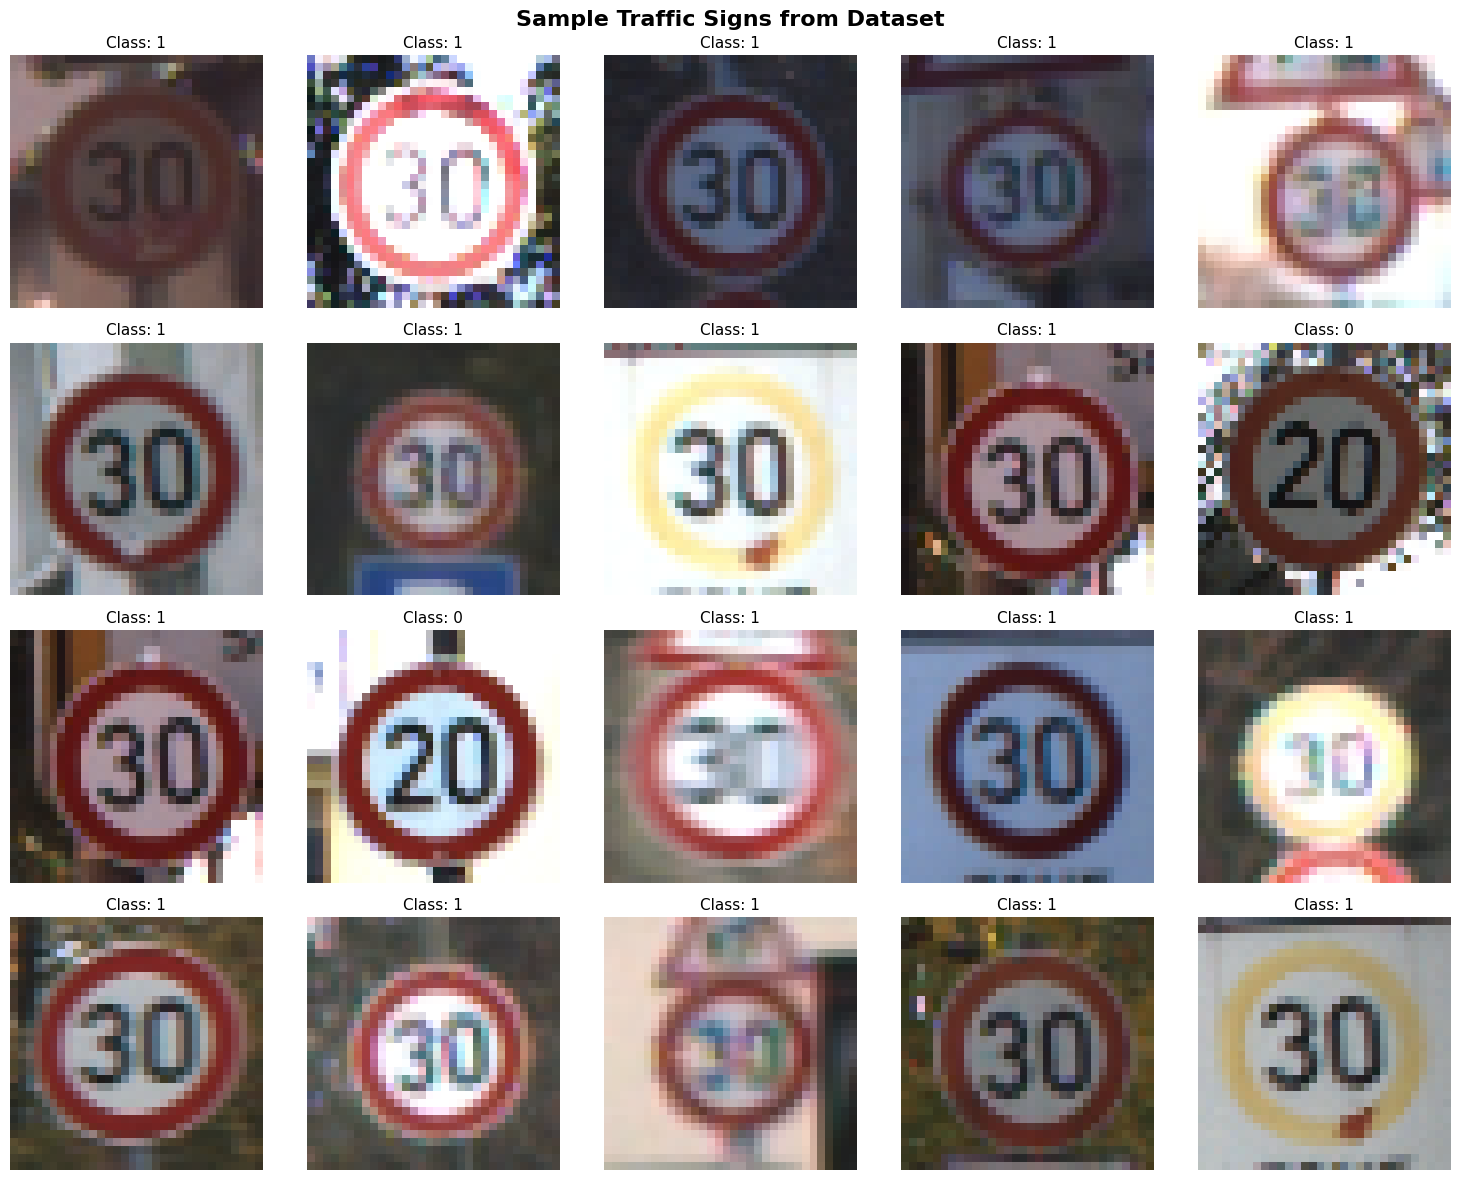


Plotting class distribution...


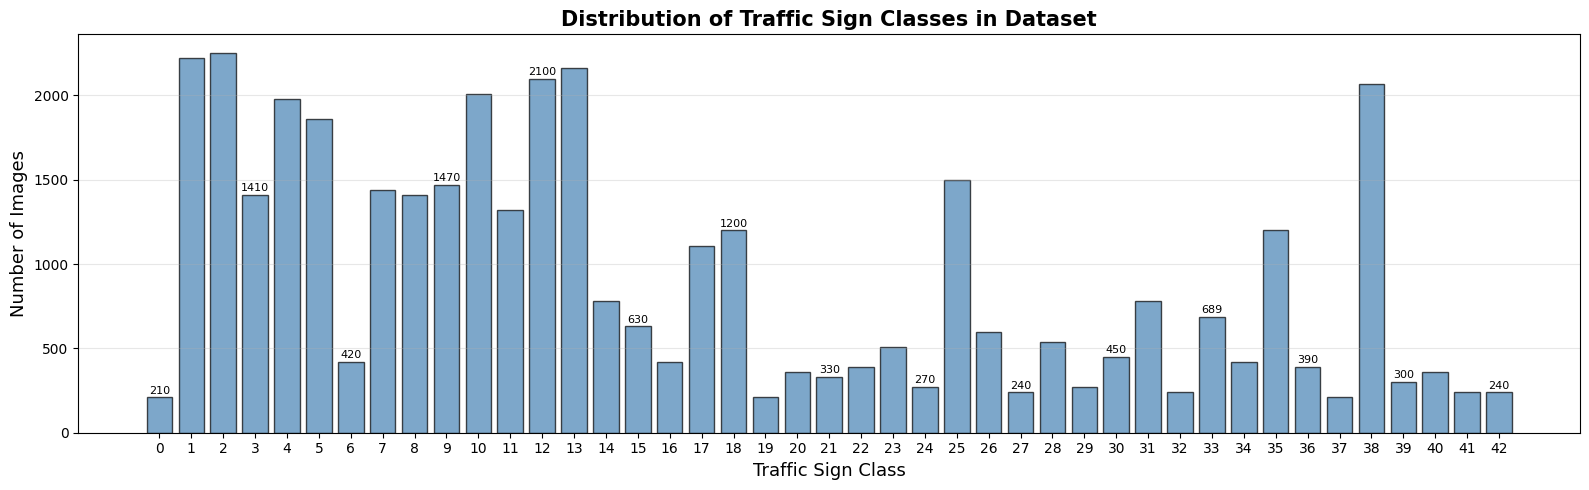


✓ Class distribution plotted
  Min samples per class: 210
  Max samples per class: 2250
  Average samples per class: 912

BUILDING MLP MODEL

✓ Model built successfully


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Traffic_Sign_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,746,731 (6.66 MB)

 Trainable params: 1,744,939 (6.66 MB)

 Non-trainable params: 1,792 (7.00 KB)


TRAINING MODEL
Epoch 1/50
211/215 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2292 - loss: 3.1404
Epoch 1: val_accuracy improved from None to 0.47713, saving model to ../models/best_traffic_sign_mlp.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3683 - loss: 2.3956 - val_accuracy: 0.4771 - val_loss: 1.7826 - learning_rate: 0.0010
Epoch 2/50
210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6062 - loss: 1.3385
Epoch 2: val_accuracy improved from 0.47713 to 0.50944, saving model to ../models/best_traffic_sign_mlp.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6393 - loss: 1.2101 - val_accuracy: 0.5094 - val_loss: 1.6968 - learning_rate: 0.0010
Epoch 3/50
210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6863 - loss: 1.0283
Epoch 3: val_accuracy improved from 0.50944 to 0.59310, saving model to ../models/best_traffic_sign_mlp.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6925 - loss: 1.0027 - val_accuracy: 0.5931 - val_loss: 1.4172 - learning_rate: 0.0010
Epoch 4/50
213/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7401 - loss: 0.8480
Epoch 4: val_accuracy improved from 0.59310 to 0.73763, saving model to ../models/best_traffic_sign_mlp.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7431 - loss: 0.8387 - val_accuracy: 0.7376 - val_loss: 0.8431 - learning_rate: 0.0010
Epoch 5/50
211/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7452 - loss: 0.8279
Epoch 5: val_accuracy improved from 0.73763 to 0.77742, saving model to ../models/best_traffic_sign_mlp.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7565 - loss: 0.7939 - val_accuracy: 0.7774 - val_loss: 0.7100 - learning_rate: 0.0010
Epoch 6/50
210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7824 - loss: 0.7151
Epoch 6: val_accuracy improved from 0.77742 to 0.84833, saving model to ../models/best_traffic_sign_mlp.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7936 - loss: 0.6741 - val_accuracy: 0.8483 - val_loss: 0.4998 - learning_rate: 0.0010
Epoch 7/50
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8043 - loss: 0.6370
Epoch 7: val_accuracy did not improve from 0.84833
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8118 - loss: 0.6069 - val_accuracy: 0.7915 - val_loss: 0.6964 - learning_rate: 0.0010
Epoch 8/50
210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8123 - loss: 0.5952
Epoch 8: val_accuracy improved from 0.84833 to 0.87672, saving model to ../models/best_traffic_sign_mlp.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8204 - loss: 0.5753 - val_accuracy: 0.8767 - val_loss: 0.4131 - learning_rate: 0.0010
Epoch 9/50
213/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8308 - loss: 0.5506
Epoch 9: val_accuracy did not improve from 0.87672
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8368 - loss: 0.5346 - val_accuracy: 0.8658 - val_loss: 0.4231 - learning_rate: 0.0010
Epoch 10/50
209/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8341 - loss: 0.5347
Epoch 10: val_accuracy did not improve from 0.87672
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8383 - loss: 0.5222 - val_accuracy: 0.8585 - val_loss: 0.4559 - learning_rate: 0.0010
Epoch 11/50
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8389 - loss: 0.5189
Epoch 11: val_accuracy improved from 0.87672 to 0.88284, saving model to ../models/best_traffic_sign_mlp.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8442 - loss: 0.5087 - val_accuracy: 0.8828 - val_loss: 0.3946 - learning_rate: 0.0010
Epoch 12/50
211/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8486 - loss: 0.4776
Epoch 12: val_accuracy improved from 0.88284 to 0.89645, saving model to ../models/best_traffic_sign_mlp.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8511 - loss: 0.4739 - val_accuracy: 0.8964 - val_loss: 0.3421 - learning_rate: 0.0010
Epoch 13/50
211/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8594 - loss: 0.4573
Epoch 13: val_accuracy did not improve from 0.89645
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8584 - loss: 0.4559 - val_accuracy: 0.8822 - val_loss: 0.3913 - learning_rate: 0.0010
Epoch 14/50
210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8547 - loss: 0.4700
Epoch 14: val_accuracy did not improve from 0.89645
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8644 - loss: 0.4363 - val_accuracy: 0.8925 - val_loss: 0.3613 - learning_rate: 0.0010
Epoch 15/50
212/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8679 - loss: 0.4208
Epoch 15: val_accuracy did not improve from 0.89645
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8724 - loss: 0.4084 - val_accuracy: 0.8854 - val_loss: 0.3760 - learning_rate: 0.0010
Epoch 16/50
213/215

215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8680 - loss: 0.4202 - val_accuracy: 0.9150 - val_loss: 0.2766 - learning_rate: 0.0010
Epoch 17/50
212/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8780 - loss: 0.3954
Epoch 17: val_accuracy improved from 0.91498 to 0.93913, saving model to ../models/best_traffic_sign_mlp.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8795 - loss: 0.3889 - val_accuracy: 0.9391 - val_loss: 0.2010 - learning_rate: 0.0010
Epoch 18/50
210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8875 - loss: 0.3658
Epoch 18: val_accuracy did not improve from 0.93913
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8843 - loss: 0.3743 - val_accuracy: 0.9264 - val_loss: 0.2421 - learning_rate: 0.0010
Epoch 19/50
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8784 - loss: 0.3809
Epoch 19: val_accuracy did not improve from 0.93913
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8785 - loss: 0.3851 - val_accuracy: 0.9221 - val_loss: 0.2576 - learning_rate: 0.0010
Epoch 20/50
212/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8929 - loss: 0.3503
Epoch 20: val_accuracy did not improve from 0.93913
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8906 - loss: 0.3507 - val_accuracy: 0.9214 - val_loss: 0.2736 - learning_rate: 0.0010
Epoch 21/50
213/215

215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9162 - loss: 0.2716 - val_accuracy: 0.9536 - val_loss: 0.1627 - learning_rate: 5.0000e-04
Epoch 24/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9144 - loss: 0.2742
Epoch 24: val_accuracy did not improve from 0.95358
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9161 - loss: 0.2697 - val_accuracy: 0.9519 - val_loss: 0.1602 - learning_rate: 5.0000e-04
Epoch 25/50
211/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9213 - loss: 0.2532
Epoch 25: val_accuracy did not improve from 0.95358
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9216 - loss: 0.2549 - val_accuracy: 0.9398 - val_loss: 0.1919 - learning_rate: 5.0000e-04
Epoch 26/50
211/215 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9212 - loss: 0.2545
Epoch 26: val_accuracy did not improve from 0.95358
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9226 - loss: 0.2549 - val_accuracy: 0.9459 - val_loss: 0.1820 - learning_rate: 5.0000e-04

215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9230 - loss: 0.2497 - val_accuracy: 0.9573 - val_loss: 0.1425 - learning_rate: 5.0000e-04
Epoch 28/50
211/215 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9220 - loss: 0.2488
Epoch 28: val_accuracy improved from 0.95732 to 0.96055, saving model to ../models/best_traffic_sign_mlp.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9227 - loss: 0.2514 - val_accuracy: 0.9606 - val_loss: 0.1385 - learning_rate: 5.0000e-04
Epoch 29/50
213/215 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9236 - loss: 0.2484
Epoch 29: val_accuracy did not improve from 0.96055
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9222 - loss: 0.2494 - val_accuracy: 0.9476 - val_loss: 0.1792 - learning_rate: 5.0000e-04
Epoch 30/50
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9183 - loss: 0.2542
Epoch 30: val_accuracy improved from 0.96055 to 0.96276, saving model to ../models/best_traffic_sign_mlp.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9211 - loss: 0.2505 - val_accuracy: 0.9628 - val_loss: 0.1345 - learning_rate: 5.0000e-04
Epoch 31/50
210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9247 - loss: 0.2365
Epoch 31: val_accuracy did not improve from 0.96276
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9247 - loss: 0.2406 - val_accuracy: 0.9583 - val_loss: 0.1507 - learning_rate: 5.0000e-04
Epoch 32/50
211/215 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9242 - loss: 0.2441
Epoch 32: val_accuracy did not improve from 0.96276
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9255 - loss: 0.2404 - val_accuracy: 0.9551 - val_loss: 0.1529 - learning_rate: 5.0000e-04
Epoch 33/50
211/215 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9282 - loss: 0.2246
Epoch 33: val_accuracy did not improve from 0.96276
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9281 - loss: 0.2283 - val_accuracy: 0.9572 - val_loss: 0.1389 - learning_rate: 5.0000e-0

215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9417 - loss: 0.1898 - val_accuracy: 0.9706 - val_loss: 0.0979 - learning_rate: 2.5000e-04
Epoch 42/50
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9429 - loss: 0.1823
Epoch 42: val_accuracy did not improve from 0.97058
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9420 - loss: 0.1861 - val_accuracy: 0.9667 - val_loss: 0.1159 - learning_rate: 2.5000e-04
Epoch 43/50
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9422 - loss: 0.1863
Epoch 43: val_accuracy did not improve from 0.97058
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9411 - loss: 0.1870 - val_accuracy: 0.9667 - val_loss: 0.1237 - learning_rate: 2.5000e-04
Epoch 44/50
211/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9412 - loss: 0.1846
Epoch 44: val_accuracy did not improve from 0.97058
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9416 - loss: 0.1856 - val_accuracy: 0.9626 - val_loss: 0.1320 - learning_rate: 2.5000e-04
Epo

215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9487 - loss: 0.1632 - val_accuracy: 0.9765 - val_loss: 0.0891 - learning_rate: 1.2500e-04
Epoch 48/50
211/215 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9490 - loss: 0.1654
Epoch 48: val_accuracy did not improve from 0.97653
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9494 - loss: 0.1627 - val_accuracy: 0.9742 - val_loss: 0.0932 - learning_rate: 1.2500e-04
Epoch 49/50
211/215 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9507 - loss: 0.1594
Epoch 49: val_accuracy did not improve from 0.97653
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9518 - loss: 0.1582 - val_accuracy: 0.9728 - val_loss: 0.0981 - learning_rate: 1.2500e-04
Epoch 50/50
213/215 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9490 - loss: 0.1603
Epoch 50: val_accuracy did not improve from 0.97653
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9483 - loss: 0.1647 - val_accuracy: 0.9725 - val_loss: 0.1002 - learning_rate: 1.2500e-0

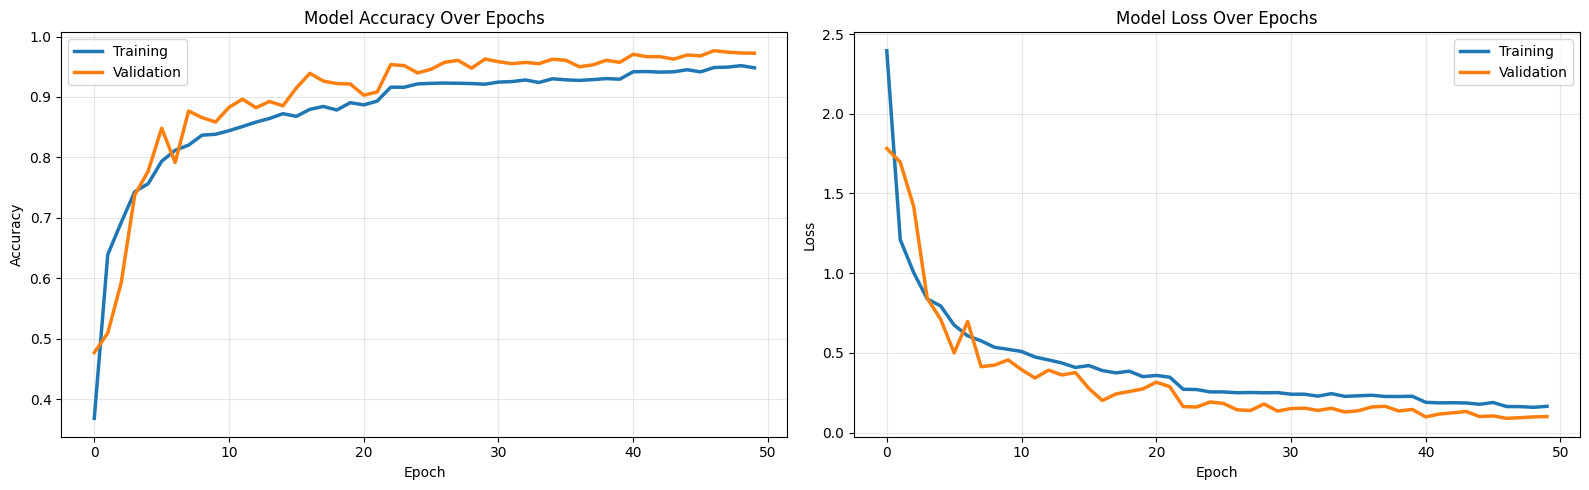


EVALUATING MODEL

  TEST ACCURACY: 97.16%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        31
           1       0.93      0.98      0.95       333
           2       0.96      0.95      0.96       338
           3       0.93      0.92      0.93       212
           4       0.96      0.96      0.96       297
           5       0.93      0.92      0.93       279
           6       1.00      0.97      0.98        63
           7       0.99      0.93      0.95       216
           8       0.96      0.97      0.96       212
           9       0.99      0.98      0.99       221
          10       0.98      0.99      0.98       302
          11       0.97      0.98      0.98       198
          12       1.00      1.00      1.00       315
          13       0.99      1.00      0.99       324
          14       0.99      1.00      1.00       117
          15       0.96      0.98      0.97        95
          16 

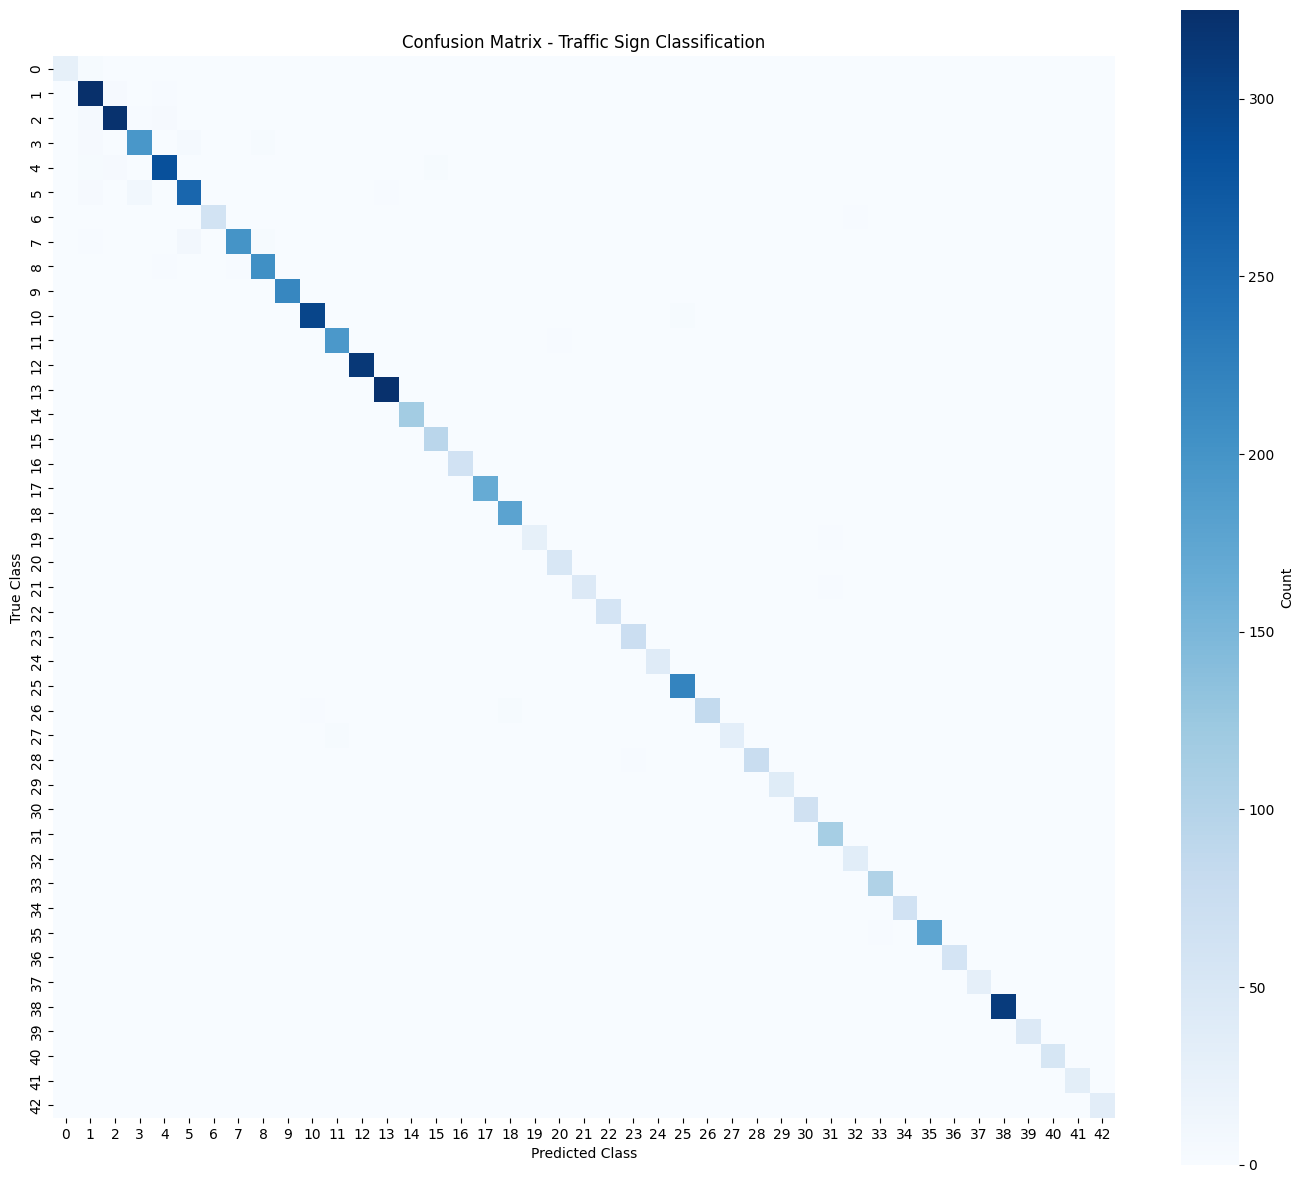


Visualizing predictions...


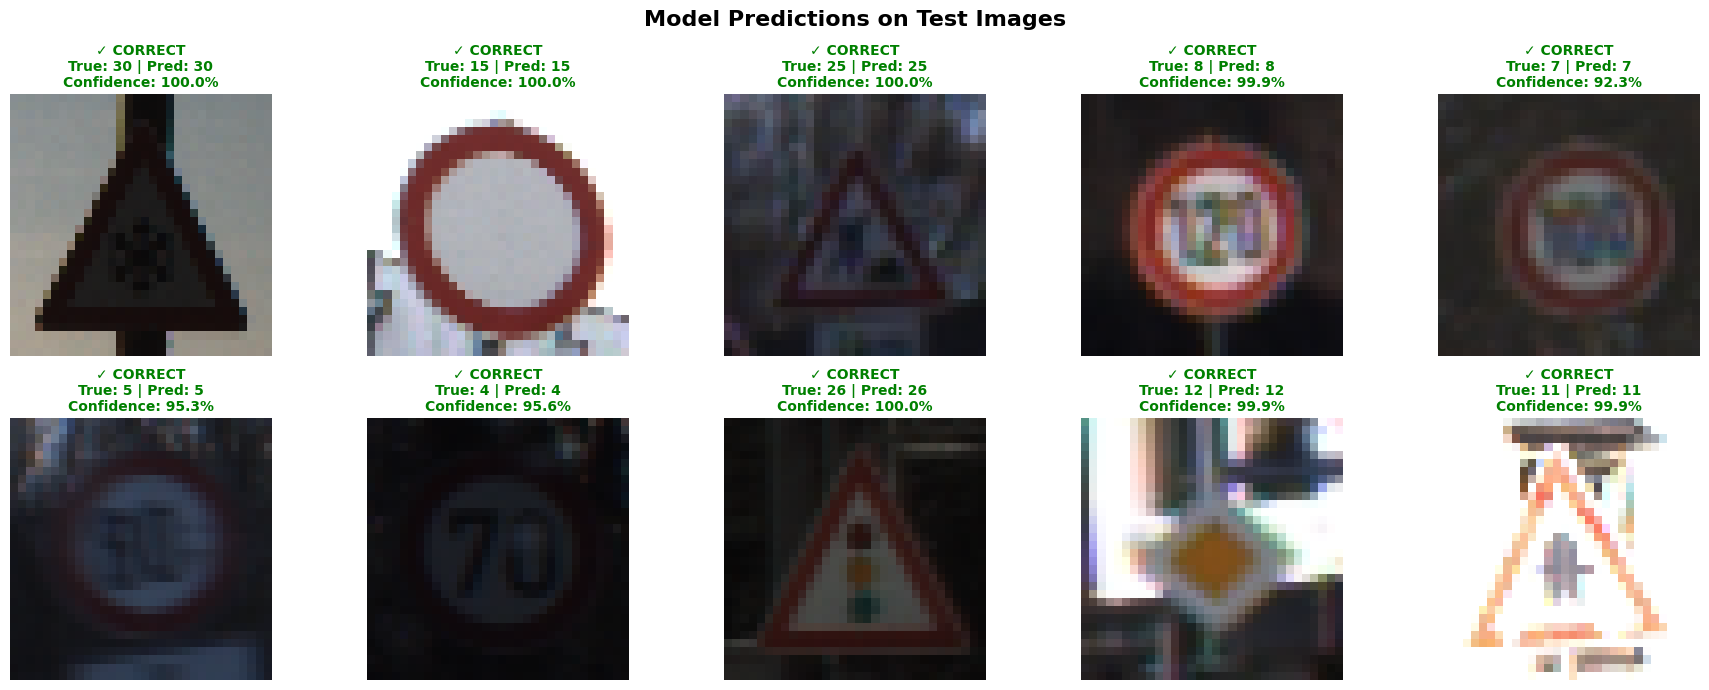


✓ Model saved as '../models/traffic_sign_mlp_final.h5'
✓ Model info saved as '../models/model_info.pkl'

  TRAINING COMPLETE!

To predict new images, use:
  predict_traffic_sign('../models/traffic_sign_mlp_final.h5', 'your_image.png')


In [10]:
# Run Complete Pipeline
main()